In [4]:
import pandas as pd
import os
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import seaborn as sns
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from utils.FeatureTransformer import ADRThirdQuartileDeviationTransformer
from utils.preprocessor import preprocessor
import numpy as np

In [5]:
df = pd.read_csv('../Dataset/df_cleaned.csv')


def convenient_split_data(data, test_size=0.25, random_state=42):

    data = data.copy()

    
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    month_map = {month: f"{i:02d}" for i, month in enumerate(month_order, 1)}
    data['MonthNum'] = data['ArrivalDateMonth'].map(month_map)

    
    data['YearMonth'] = data['ArrivalDateYear'].astype(str) + '-' + data['MonthNum']

    
    data = data.sort_values(['ArrivalDateYear', 'MonthNum', 'ArrivalDateDayOfMonth'])

    
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

    for block in data['YearMonth'].unique():
        block_data = data[data['YearMonth'] == block]
        X_block = block_data.drop(columns=['IsCanceled', 'YearMonth', 'MonthNum'])
        y_block = block_data['IsCanceled']

        
        stratify = y_block if y_block.nunique() > 1 else None

        X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
            X_block, y_block, test_size=test_size, stratify=stratify, random_state=random_state
        )

        X_train_list.append(X_train_b)
        X_test_list.append(X_test_b)
        y_train_list.append(y_train_b)
        y_test_list.append(y_test_b)

    
    X_train = pd.concat(X_train_list).reset_index(drop=True)
    X_test = pd.concat(X_test_list).reset_index(drop=True)
    y_train = pd.concat(y_train_list).reset_index(drop=True)
    y_test = pd.concat(y_test_list).reset_index(drop=True)

    return X_train, X_test, y_train, y_test

X_cs_train, X_cs_test, y_cs_train, y_cs_test = convenient_split_data(df)





C:\Users\tomma\AppData\Local\Temp\ipykernel_18716\1865468440.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df.head(25), x="Importance", y="Feature", palette=palette[:25])


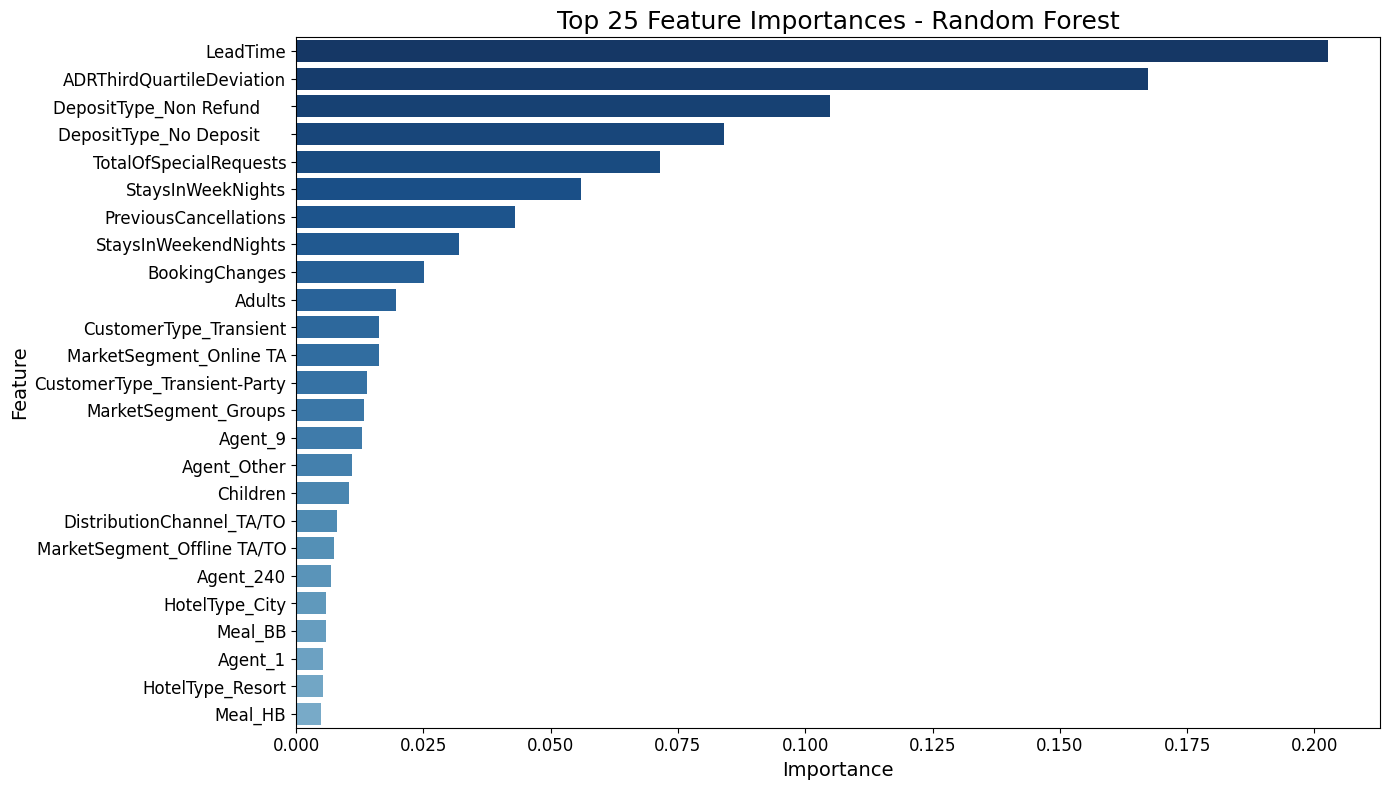

C:\Users\tomma\AppData\Local\Temp\ipykernel_18716\1865468440.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df_sorted, x="Feature", y="Importance", palette=palette)


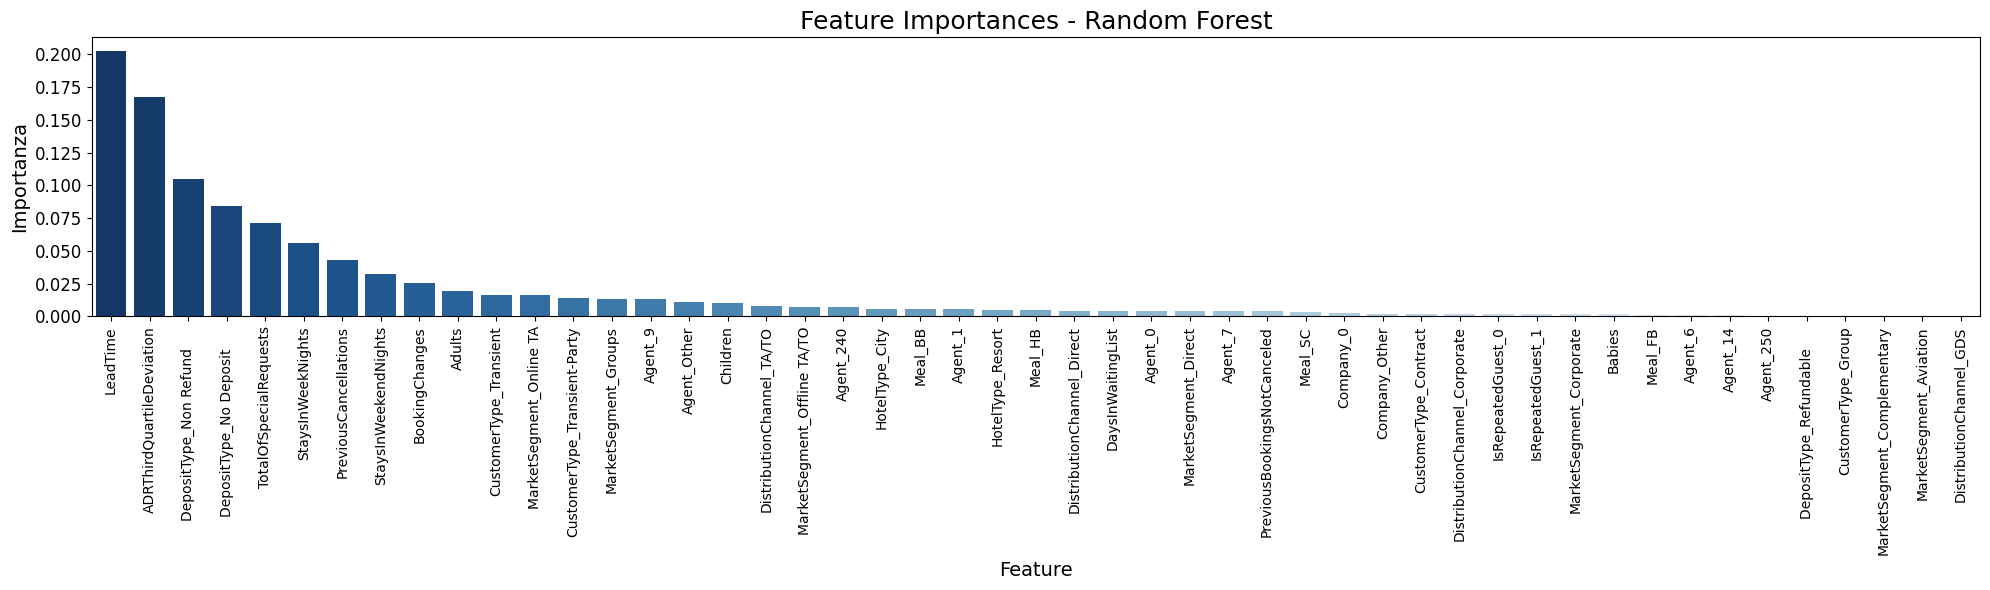

In [14]:
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

grid_df = pd.read_csv("grid_search_results.csv")

def get_best_params(model_name):
    row = grid_df[grid_df['Model'] == model_name].iloc[0]
    if row['Best Params'] == 'Default':
        return {}
    raw_params = ast.literal_eval(row['Best Params'])
    return {k.replace("clf__", ""): v for k, v in raw_params.items()}

best_params = get_best_params("Random Forest")

preprocess = Pipeline([
    ('feature_eng', ADRThirdQuartileDeviationTransformer()),  
    ('preproc', preprocessor)  
])

X_train_proc = preprocess.fit_transform(X_cs_train)
X_test_proc = preprocess.transform(X_cs_test)
feature_names = preprocess.named_steps['preproc'].get_feature_names_out()
feature_names_clean = [name.split('__')[-1] for name in feature_names]

rf = RandomForestClassifier(**best_params, random_state=42)
rf.fit(X_train_proc, y_cs_train)

importances = rf.feature_importances_
feat_df = pd.DataFrame({
    "Feature": feature_names_clean,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

palette = sns.color_palette("Blues", len(feat_df))
palette.reverse()

plt.figure(figsize=(14, 8))
sns.barplot(data=feat_df.head(25), x="Importance", y="Feature", palette=palette[:25])
plt.title("Top 25 Feature Importances - Random Forest", fontsize=18)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

feat_df_sorted = feat_df.sort_values(by="Importance", ascending=False)

palette = sns.color_palette("Blues", n_colors=len(feat_df_sorted))
palette = palette[::-1]  


plt.figure(figsize=(20, 6))
sns.barplot(data=feat_df_sorted, x="Feature", y="Importance", palette=palette)
plt.title("Feature Importances - Random Forest", fontsize=18)
plt.xlabel("Feature", fontsize=14)
plt.ylabel("Importanza", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [9]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=20000, random_state=42)
for train_idx, sample_idx in strat_split.split(X_cs_train, y_cs_train):
    X_sample = X_cs_train.iloc[sample_idx]
    y_sample = y_cs_train.iloc[sample_idx]

def get_best_params(model_name, grid_df):
    row = grid_df[grid_df['Model']==model_name].iloc[0]
    if row['Best Params']=='Default':
        return {}
    raw = ast.literal_eval(row['Best Params'])
    
    return {k.replace('clf__',''): v for k,v in raw.items()}


rf = RandomForestClassifier(
    **get_best_params("Random Forest", grid_df),
    random_state=42
)

pipeline = Pipeline([
    ('feature_eng', ADRThirdQuartileDeviationTransformer()),
    ('preproc', preprocessor),
    ('clf',         rf)
])

pipeline.fit(X_sample,y_sample)



Pipeline(steps=[('feature_eng', ADRThirdQuartileDeviationTransformer()),
                ('preproc',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['LeadTime',
                                                   'StaysInWeekendNights',
                                                   'StaysInWeekNights',
                                                   'Adults', 'Children',
                                                   'Babies',
                                                   'ADRThirdQuartileDeviation',
                                                   'PreviousCancellations',
                                                   'PreviousBookingsNotCanceled',
                                                   'BookingChanges',
                                                   'DaysInWaitingList',
                                                   'TotalOfSpecialRequests']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Meal', 'MarketSegment',
                                                   'DistributionChannel',
                                                   'DepositType',
                                                   'CustomerType', 'HotelType',
                                                   'Agent', 'Company',
                                                   'IsRepeatedGuest'])])),
                ('clf',
                 RandomForestClassifier(max_depth=30, n_estimators=300,
                                        random_state=42))])

100%|===================| 39994/40000 [111:42<00:01]        

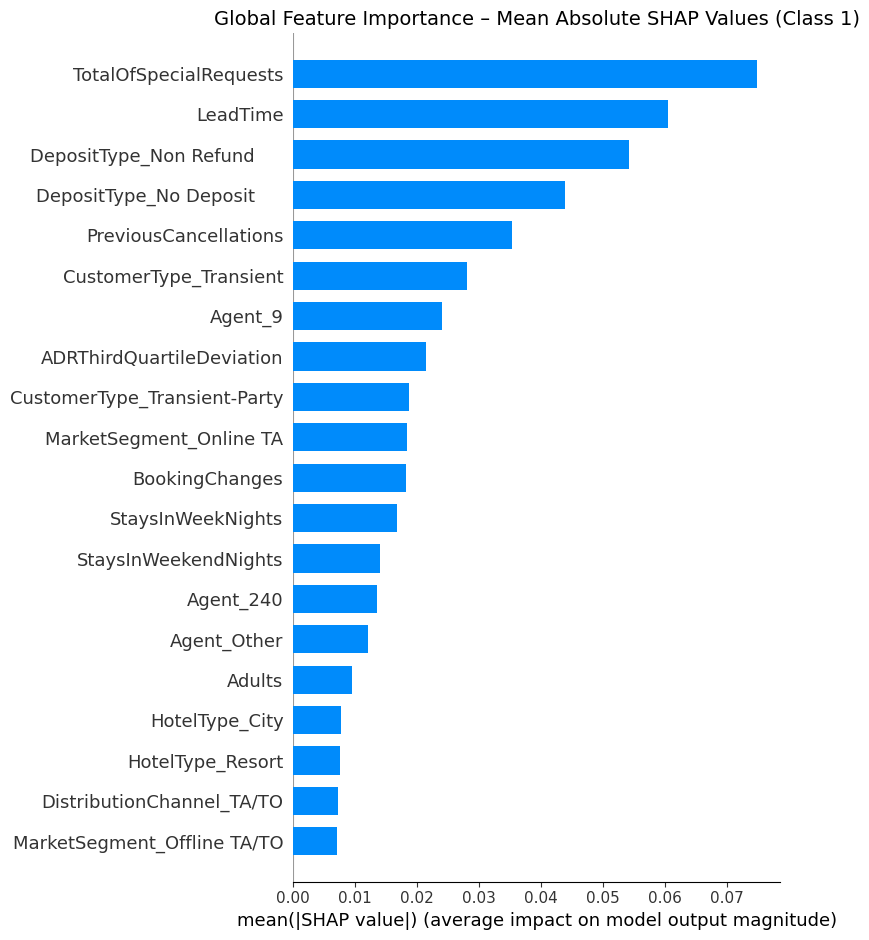

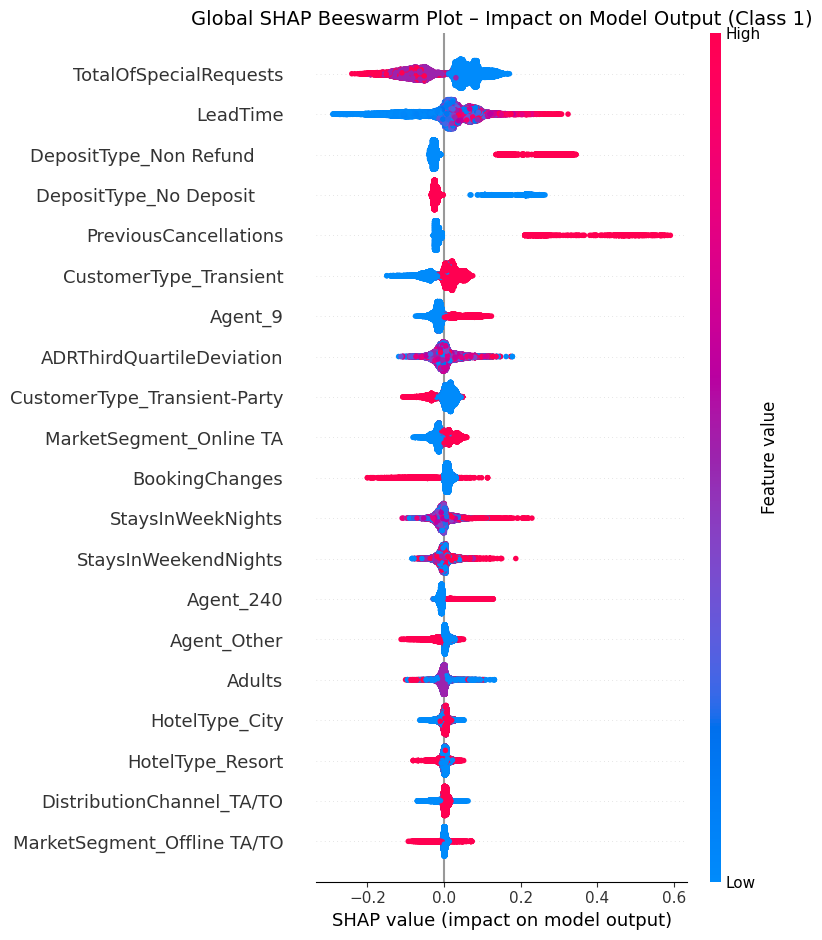

In [ ]:
MODEL_NAME = "random_forest"
CSV_DIR    = "shap_csv"
IMG_DIR    = "shap_img"

os.makedirs(f"{CSV_DIR}/{MODEL_NAME}", exist_ok=True)
os.makedirs(f"{IMG_DIR}/{MODEL_NAME}/shap_summary", exist_ok=True)

X_eng = pipeline.named_steps['feature_eng'].transform(X_sample)
X_pre = pipeline.named_steps['preproc'].transform(X_eng)
feat_names = pipeline.named_steps['preproc'].get_feature_names_out()
rf_model = pipeline.named_steps['clf']

explainer = shap.TreeExplainer(
    rf_model,
    data=X_pre,
    feature_perturbation="interventional"
)
shap_vals_raw = explainer.shap_values(X_pre, check_additivity=False)

if isinstance(shap_vals_raw, np.ndarray) and shap_vals_raw.ndim == 3:
    shap_vals = shap_vals_raw[:, :, 1]
elif isinstance(shap_vals_raw, list) and len(shap_vals_raw) == 2:
    shap_vals = shap_vals_raw[1]
else:
    shap_vals = shap_vals_raw 

pd.DataFrame(shap_vals, columns=feat_names).to_csv(f"{CSV_DIR}/{MODEL_NAME}/shap_values_class1.csv", index=False)
pd.DataFrame(X_pre, columns=feat_names).to_csv(f"{CSV_DIR}/{MODEL_NAME}/X_preprocessed.csv", index=False)

base_value = explainer.expected_value[1]
with open(f"{CSV_DIR}/{MODEL_NAME}/base_value.txt", "w") as f:
    f.write(str(base_value))

clean_feat_names = [f.replace("num__", "").replace("onehot__", "") for f in feat_names]

shap.summary_plot(
    shap_vals,
    X_pre,
    feature_names=clean_feat_names,
    plot_type="bar",
    show=False
)
plt.title("Global Feature Importance – Mean Absolute SHAP Values (Class 1)", fontsize=14)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/{MODEL_NAME}/shap_summary/bar.png", dpi=150)
plt.show()

shap.summary_plot(
    shap_vals,
    X_pre,
    feature_names=clean_feat_names,
    show=False
)
plt.title("Global SHAP Beeswarm Plot – Impact on Model Output (Class 1)", fontsize=14)
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/{MODEL_NAME}/shap_summary/beeswarm.png", dpi=150)
plt.show()


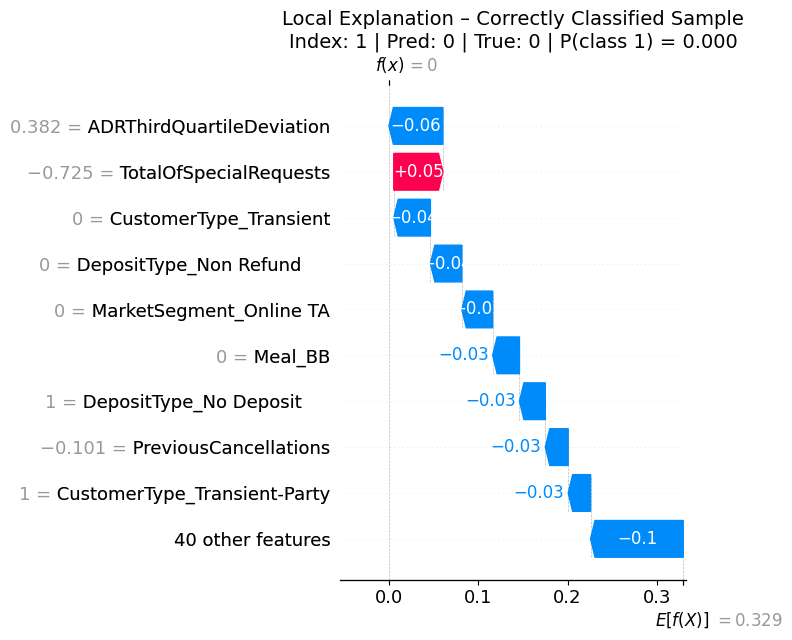

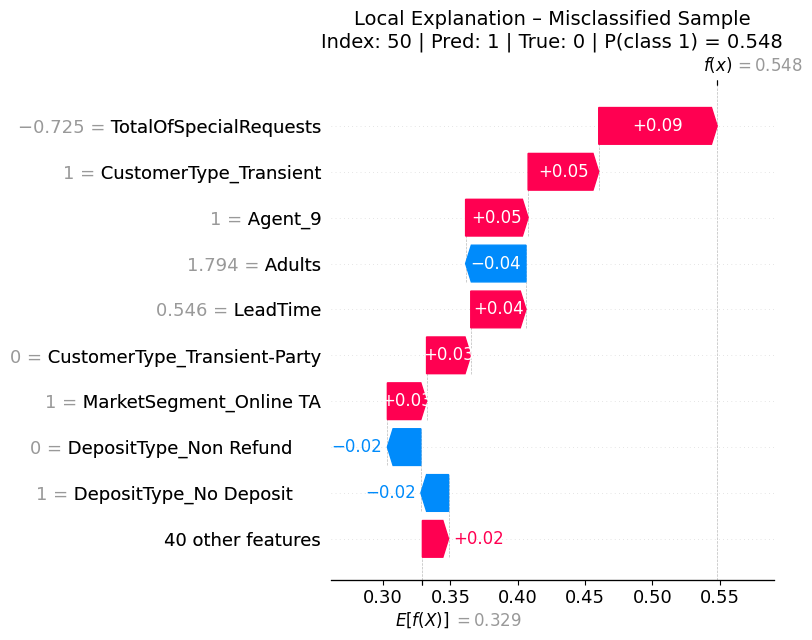

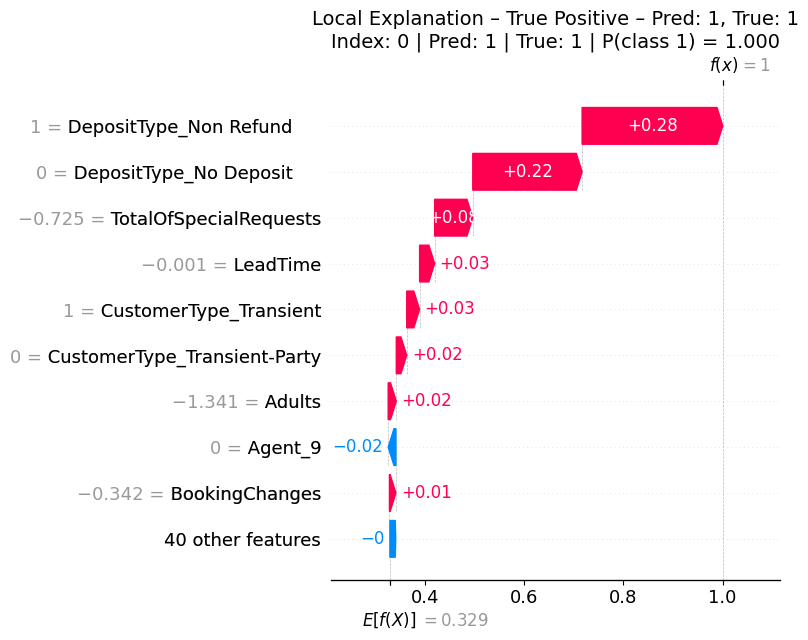

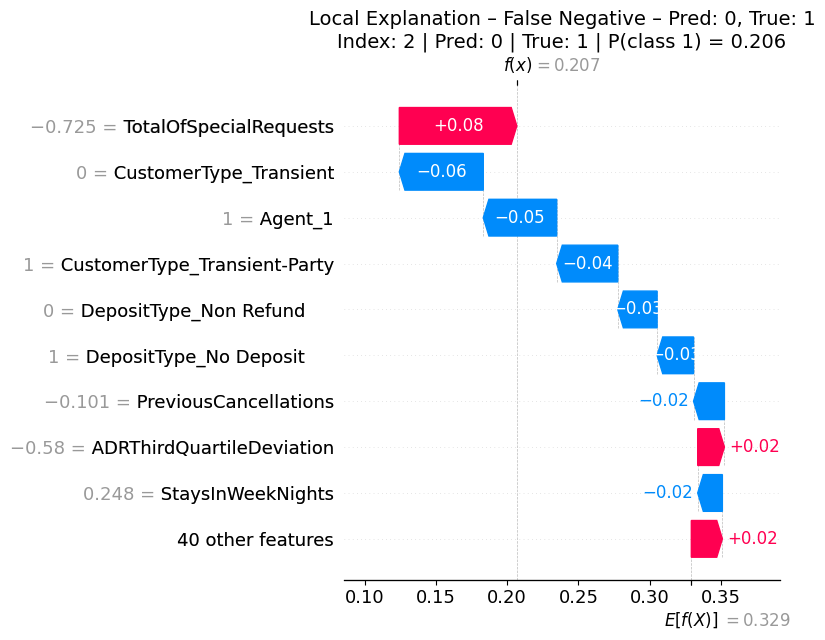

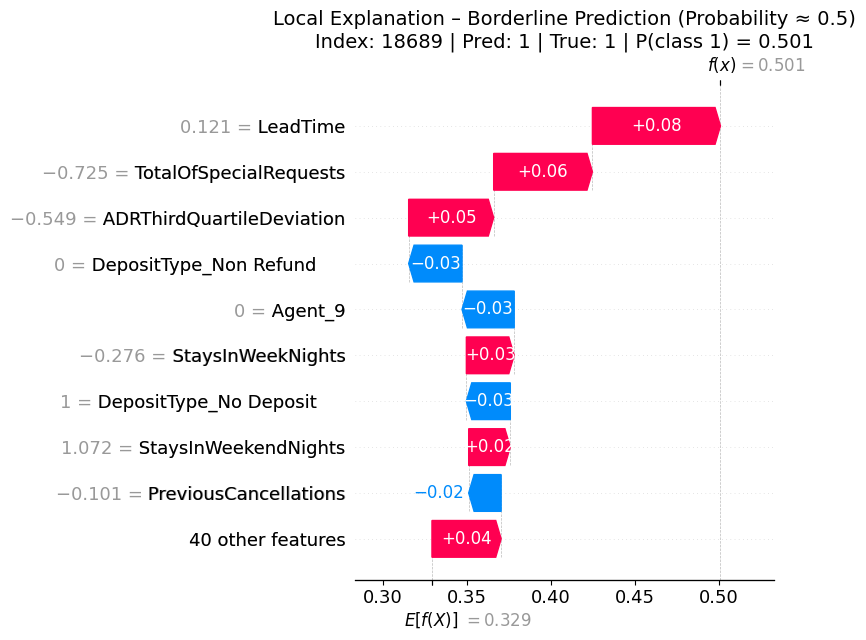

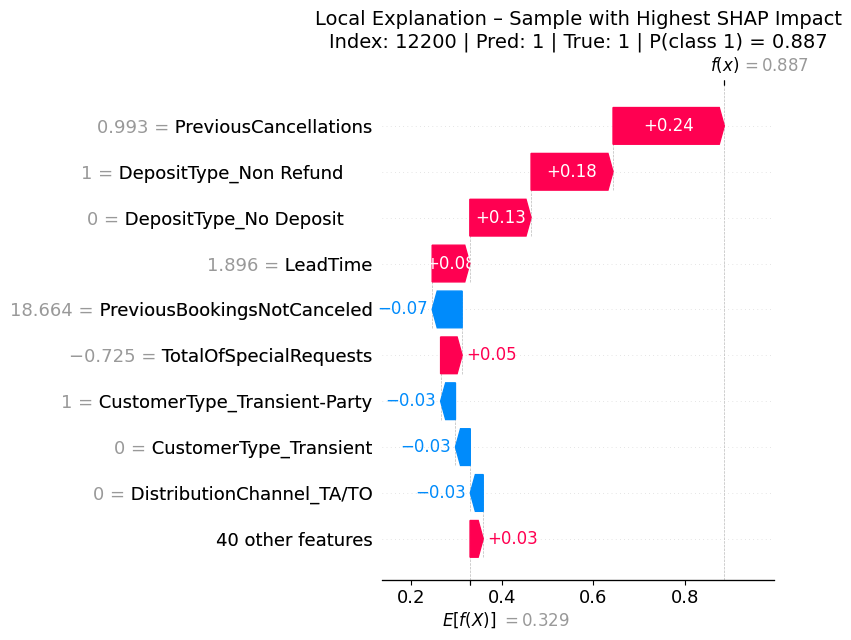

In [7]:

MODEL_NAME = "random_forest"
CSV_DIR    = "shap_csv"
IMG_DIR    = "shap_img"

X_pre = pd.read_csv(f"{CSV_DIR}/{MODEL_NAME}/X_preprocessed.csv").values
shap_vals = pd.read_csv(f"{CSV_DIR}/{MODEL_NAME}/shap_values_class1.csv").values
with open(f"{CSV_DIR}/{MODEL_NAME}/base_value.txt", "r") as f:
    base_value = float(f.read())


y_true = y_sample.values
y_pred = rf_model.predict(X_pre)
y_proba = rf_model.predict_proba(X_pre)[:, 1]

indices = {
    "correct": np.where((y_true == 0) & (y_pred == 0))[0][0],
    "wrong": np.where((y_true == 0) & (y_pred == 1))[0][0],
    "true_positive": np.where((y_true == 1) & (y_pred == 1))[0][0],
    "false_negative": np.where((y_true == 1) & (y_pred == 0))[0][0],
    "borderline": np.argmin(np.abs(y_proba - 0.5)),
    "extreme": np.argmax(np.abs(shap_vals).sum(axis=1)),
}

titles = {
    "correct": "Correctly Classified Sample",
    "wrong": "Misclassified Sample",
    "borderline": "Borderline Prediction (Probability ≈ 0.5)",
    "extreme": "Sample with Highest SHAP Impact",
    "true_positive": "True Positive – Pred: 1, True: 1",
    "false_negative": "False Negative – Pred: 0, True: 1"
}

for label, i in indices.items():
    exp = shap.Explanation(
        values=shap_vals[i],
        base_values=base_value,
        data=X_pre[i],
        feature_names=clean_feat_names
    )

    predicted_class = y_pred[i]
    true_class = y_true[i]
    proba_class1 = y_proba[i]

    shap.plots.waterfall(exp, show=False)
    plt.title(
        f"Local Explanation – {titles[label]}\n"
        f"Index: {i} | Pred: {predicted_class} | True: {true_class} | P(class 1) = {proba_class1:.3f}",
        fontsize=14
    )
    plt.tight_layout()
    plt.savefig(f"{IMG_DIR}/{MODEL_NAME}/shap_summary/waterfall_{label}_row_{i}.png", dpi=150)
    plt.show()
